# Application of Machine Learning Methods to Analysis of Cyber-Sport Events
## Dmitry Savostyanov, 131
## TrueSkill by Teams

### Role:
###### 1 - Carry
###### 2 - Mid
###### 3 - Hard-lane
###### 4 - Semi-support
###### 5 - Full-support

### Взаимодействие с Dotabuff:
###### Информация об игроке: https://www.dotabuff.com/esports/players/<'account_id'>

###### Информация о матче: https://www.dotabuff.com/matches/<'match_id'>

###### Информация о команде: https://www.dotabuff.com/esports/teams/<'team_id'>


In [1]:
import trueskill as ts

import urllib2
import json
import random
import datetime

import math 
import pandas as pd 
import numpy as np 
import sklearn 
import matplotlib.pyplot as plt 
 
%matplotlib inline
plt.style.use('ggplot')

# Data Import

In [2]:
sdf_1 = pd.read_csv('ScoresByRole_1.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_2 = pd.read_csv('ScoresByRole_2.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_3 = pd.read_csv('ScoresByRole_3.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_4 = pd.read_csv('ScoresByRole_4.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_5 = pd.read_csv('ScoresByRole_5.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })

In [3]:
sdf = pd.concat([sdf_1, sdf_2, sdf_3, sdf_4, sdf_5])

In [4]:
matches = sdf.sort_values(by = ['match_id', 'team_id', 'role'], ascending = False)

In [5]:
# matches

# Cumulative Score (match_id + team_id)

In [6]:
cumprob = matches.groupby(['match_id', 'team_id'], as_index=False)['win_prob'].sum()
cumprob.rename(columns = {'win_prob' : 'cumulative_prob'}, inplace = True)

In [7]:
cumprob.sort_values(by = ['match_id', 'cumulative_prob'], ascending = False, inplace = True)
# cumprob

In [8]:
matches = pd.merge(matches, cumprob, on=['match_id', 'team_id'], how='inner')
matches.rename(columns = {'win_prob_x' : 'win_prob', 'win_prob_y' : 'cumulative_prob'}, inplace = True)

In [9]:
matches['win_contribution'] = matches['win_prob'] / matches['cumulative_prob']

In [10]:
# matches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False)

In [11]:
matchesFreq = matches.groupby(['match_id'])['match_id'].count()

In [12]:
len(matchesFreq)

560

#### Избавимся от матчей, которые представлены менее чем 10 записями

In [13]:
fullMatches = matchesFreq[matchesFreq == 10]
len(fullMatches)

207

In [14]:
isFull = np.in1d(matches['match_id'], fullMatches.index.values)

In [15]:
len(isFull)

4930

In [16]:
matches['isFull'] = isFull

In [17]:
sMatches = matches[matches['isFull'] == True]

# Финальная таблица
## Описание полей:
account_id - Идентификатор игрока

match_id - Идентификатор матча

team_id - Идентификатор команды

role - Исполняемая роль (Описание См. Выше)

datetime - Дата окончания матча

win - Идентификатор победы (Целевая переменная)

win_prob - Предсказанная вероятность победы на основе информации по игроку данной роли

prediction - Предсказание со стандартным порогом отсечения (True if win_prob >= 0.5)

isCorrect - Флаг совпадения предсказания с реальностью

cumulative_prob - Сумма вероятностей победы по команде в матче

win_contribution - Вклад игрока данной роли в победу (win_prob / cumulative_prob)

isFull - Флаг того, что для данного match_id в таблице имеется ровно 10 записей (по 5 на команду)

In [18]:
sMatches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False, inplace = True)

C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
sMatches

,account_id,match_id,team_id,role,datetime,win,win_prob,prediction,isCorrect,cumulative_prob,win_contribution,isFull
3,311360822,3149572447,2586976,2.0,30.04.2017 22:09:06,True,0.998942,True,True,3.151250,0.316999,True
0,94155156,3149572447,2586976,5.0,30.04.2017 22:09:06,True,0.689940,True,True,3.151250,0.218942,True
1,26771994,3149572447,2586976,4.0,30.04.2017 22:09:06,True,0.676170,True,True,3.151250,0.214572,True
2,41231571,3149572447,2586976,3.0,30.04.2017 22:09:06,True,0.577774,True,True,3.151250,0.183348,True
4,19672354,3149572447,2586976,1.0,30.04.2017 22:09:06,True,0.208424,False,False,3.151250,0.066140,True
9,132851371,3149572447,1883502,1.0,30.04.2017 22:09:06,False,0.841920,True,False,1.934337,0.435250,True
5,134556694,3149572447,1883502,5.0,30.04.2017 22:09:06,False,0.662124,True,False,1.934337,0.342300,True
8,106573901,3149572447,1883502,2.0,30.04.2017 22:09:06,False,0.218387,False,True,1.934337,0.112900,True
6,106809101,3149572447,1883502,4.0,30.04.2017 22:09:06,False,0.148795,False,True,1.934337,0.076923,True
7,92423451,3149572447,1883502,3.0,30.04.2017 22:09:06,False,0.063111,False,True,1.934337,0.032627,True


In [20]:
m = sMatches.drop_duplicates(['match_id', 'team_id'])

In [21]:
mList = m.merge(m, left_on = 'match_id', right_on = 'match_id', how = 'left')

In [22]:
mList = mList.loc[mList['team_id_x'] != mList['team_id_y'], :]

In [23]:
matches = mList[mList['win_x'] == True].drop_duplicates(['match_id', 'team_id_x'])

In [24]:
matches = matches[['match_id', 'team_id_x', 'team_id_y', 'datetime_x', 'win_x', 'cumulative_prob_x', 'cumulative_prob_y']]

In [25]:
matches['isCorrectCS'] = matches.apply(lambda row: row['cumulative_prob_x'] > row['cumulative_prob_y'], axis = 1)

In [26]:
matches

,match_id,team_id_x,team_id_y,datetime_x,win_x,cumulative_prob_x,cumulative_prob_y,isCorrectCS
1,3149572447,2586976,1883502,30.04.2017 22:09:06,True,3.151250,1.934337,True
6,3149353238,1883502,2586976,30.04.2017 19:46:31,True,4.790750,0.460987,True
10,3148721353,2586976,39,30.04.2017 14:32:58,True,3.503708,2.258431,True
14,3148357328,1883502,5,30.04.2017 11:13:45,True,4.512292,2.704387,True
18,3148230043,1883502,5,30.04.2017 10:00:15,True,4.834147,1.031717,True
21,3147569106,39,3580606,30.04.2017 00:39:15,True,4.776569,1.616667,True
26,3147464579,3580606,39,29.04.2017 23:02:49,True,3.696406,1.334994,True
29,3147338543,39,3580606,29.04.2017 21:31:07,True,4.547099,2.159986,True
34,3147190590,1883502,3547682,29.04.2017 19:59:13,True,4.729478,1.004696,True
38,3147083553,1883502,3547682,29.04.2017 19:01:28,True,4.819835,0.494179,True


In [27]:
accuracy = float(matches['isCorrectCS'].sum()) / float(len(matches['isCorrectCS']))

In [28]:
print accuracy

0.923076923077


Инициализация рейтингов TrueSkill

In [29]:
trs = {}
for i in range(0, matches.shape[0]):
    trs[matches['team_id_x'].iloc[i]] = ts.Rating()
    trs[matches['team_id_y'].iloc[i]] = ts.Rating()

In [30]:
for i in range(0, matches.shape[0]):
    trs[matches['team_id_x'].iloc[i]], trs[matches['team_id_y'].iloc[i]] = ts.rate_1vs1(trs[matches['team_id_x'].iloc[i]], trs[matches['team_id_y'].iloc[i]])

In [31]:
from operator import itemgetter
trueSkill_team = sorted(trs.items(), key=itemgetter(1), reverse=True)

In [32]:
trs = pd.DataFrame(trueSkill_team, columns = ['team_id', 'rating'])

In [33]:
for i in range(len(trs)):
    trs.loc[i, 'tsMu'] = trs.iloc[i,1].mu
    trs.loc[i, 'tsSigma'] =  trs.iloc[i,1].sigma

In [34]:
trs.drop('rating',1, inplace = True)

In [35]:
trs

,team_id,tsMu,tsSigma
0,1883502,32.420142,2.358422
1,3331948,31.622287,2.463121
2,3,30.358831,6.405348
3,2108395,30.325233,3.328320
4,1838315,28.042842,2.665033
5,2621843,26.718798,3.942826
6,2586976,26.635625,2.611851
7,5,26.397424,1.316084
8,36,25.037834,3.867430
9,726228,24.826016,1.574994


In [36]:
left = matches.merge(trs, left_on = 'team_id_x', right_on = 'team_id', how = 'left').rename(columns = {'tsMu' : 'tsMu_x', 'tsSigma' : 'tsSigma_x'})
right = matches.merge(trs, left_on = 'team_id_y', right_on = 'team_id', how = 'left').rename(columns = {'tsMu' : 'tsMu_y', 'tsSigma' : 'tsSigma_y'})
left.drop('team_id',1, inplace = True)
right.drop('team_id',1, inplace = True)

In [37]:
matches = pd.concat([left, right[['tsMu_y', 'tsSigma_y']]], axis = 1)
matches

,match_id,team_id_x,team_id_y,datetime_x,win_x,cumulative_prob_x,cumulative_prob_y,isCorrectCS,tsMu_x,tsSigma_x,tsMu_y,tsSigma_y
0,3149572447,2586976,1883502,30.04.2017 22:09:06,True,3.151250,1.934337,True,26.635625,2.611851,32.420142,2.358422
1,3149353238,1883502,2586976,30.04.2017 19:46:31,True,4.790750,0.460987,True,32.420142,2.358422,26.635625,2.611851
2,3148721353,2586976,39,30.04.2017 14:32:58,True,3.503708,2.258431,True,26.635625,2.611851,24.023614,2.016185
3,3148357328,1883502,5,30.04.2017 11:13:45,True,4.512292,2.704387,True,32.420142,2.358422,26.397424,1.316084
4,3148230043,1883502,5,30.04.2017 10:00:15,True,4.834147,1.031717,True,32.420142,2.358422,26.397424,1.316084
5,3147569106,39,3580606,30.04.2017 00:39:15,True,4.776569,1.616667,True,24.023614,2.016185,19.610963,3.708746
6,3147464579,3580606,39,29.04.2017 23:02:49,True,3.696406,1.334994,True,19.610963,3.708746,24.023614,2.016185
7,3147338543,39,3580606,29.04.2017 21:31:07,True,4.547099,2.159986,True,24.023614,2.016185,19.610963,3.708746
8,3147190590,1883502,3547682,29.04.2017 19:59:13,True,4.729478,1.004696,True,32.420142,2.358422,17.988259,1.679076
9,3147083553,1883502,3547682,29.04.2017 19:01:28,True,4.819835,0.494179,True,32.420142,2.358422,17.988259,1.679076


In [38]:
matches['cumulative_prob_dif'] = matches['cumulative_prob_x'] - matches['cumulative_prob_y']

In [62]:
def trueskill_win_probability(Team1_mu, Team1_sigma, Team2_mu, Team2_sigma):

    Team1_sigma += ts.BETA**2
    
    Team2_sigma += ts.BETA**2

    delta_mu = Team1_mu - Team2_mu
    denom = (Team1_sigma + Team2_sigma)**0.5
    
    return ts.backends.cdf(delta_mu / denom)

In [60]:
for i in range(len(matches)):
    matches.loc[i, 'tsWin_x'] = trueskill_win_probability(matches.loc[i, 'tsMu_x'], matches.loc[i, 'tsSigma_x'], matches.loc[i, 'tsMu_y'], matches.loc[i, 'tsSigma_y'])

In [61]:
matches

,match_id,team_id_x,team_id_y,datetime_x,win_x,cumulative_prob_x,cumulative_prob_y,isCorrectCS,tsMu_x,tsSigma_x,tsMu_y,tsSigma_y,cumulative_prob_dif,tsWin_x
0,3149572447,2586976,1883502,30.04.2017 22:09:06,True,3.151250,1.934337,True,26.635625,2.611851,32.420142,2.358422,1.216913,0.179271
1,3149353238,1883502,2586976,30.04.2017 19:46:31,True,4.790750,0.460987,True,32.420142,2.358422,26.635625,2.611851,4.329763,0.820729
2,3148721353,2586976,39,30.04.2017 14:32:58,True,3.503708,2.258431,True,26.635625,2.611851,24.023614,2.016185,1.245277,0.661438
3,3148357328,1883502,5,30.04.2017 11:13:45,True,4.512292,2.704387,True,32.420142,2.358422,26.397424,1.316084,1.807904,0.834463
4,3148230043,1883502,5,30.04.2017 10:00:15,True,4.834147,1.031717,True,32.420142,2.358422,26.397424,1.316084,3.802430,0.834463
5,3147569106,39,3580606,30.04.2017 00:39:15,True,4.776569,1.616667,True,24.023614,2.016185,19.610963,3.708746,3.159902,0.756107
6,3147464579,3580606,39,29.04.2017 23:02:49,True,3.696406,1.334994,True,19.610963,3.708746,24.023614,2.016185,2.361412,0.243893
7,3147338543,39,3580606,29.04.2017 21:31:07,True,4.547099,2.159986,True,24.023614,2.016185,19.610963,3.708746,2.387113,0.756107
8,3147190590,1883502,3547682,29.04.2017 19:59:13,True,4.729478,1.004696,True,32.420142,2.358422,17.988259,1.679076,3.724782,0.989778
9,3147083553,1883502,3547682,29.04.2017 19:01:28,True,4.819835,0.494179,True,32.420142,2.358422,17.988259,1.679076,4.325655,0.989778


In [63]:
from sklearn import metrics
metrics.roc_auc_score(matches['isCorrectCS'], matches['cumulative_prob_dif'])

1.0

In [64]:
from sklearn import metrics
metrics.roc_auc_score(matches['isCorrectCS'], matches['tsWin_x'])

0.3724048442906574

In [66]:
from sklearn import metrics
metrics.log_loss(matches['isCorrectCS'], matches['tsWin_x'])

0.66419071732502311

In [80]:
m_min = matches['cumulative_prob_dif'].min()
m_max = matches['cumulative_prob_dif'].max()
matches['cumulative_prob_dif_norm'] = (matches['cumulative_prob_dif'] - m_min) / (m_max - m_min)

In [82]:
from sklearn import metrics
metrics.log_loss(matches['isCorrectCS'], matches['cumulative_prob_dif_norm'])

0.20201304751076235

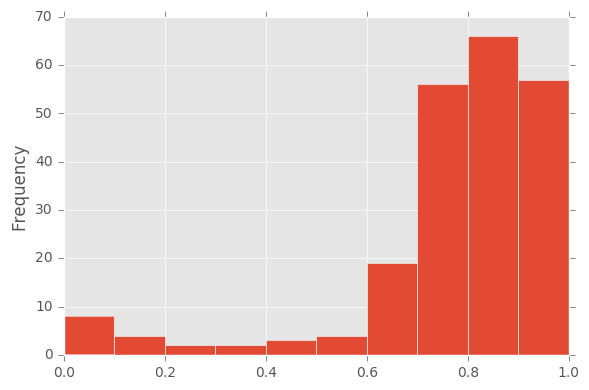

In [95]:
plot = matches['cumulative_prob_dif_norm'].plot(kind = 'hist')
fig = plot.get_figure()
plt.tight_layout()
fig.savefig("Cumulative Score.png", dpi = 400)

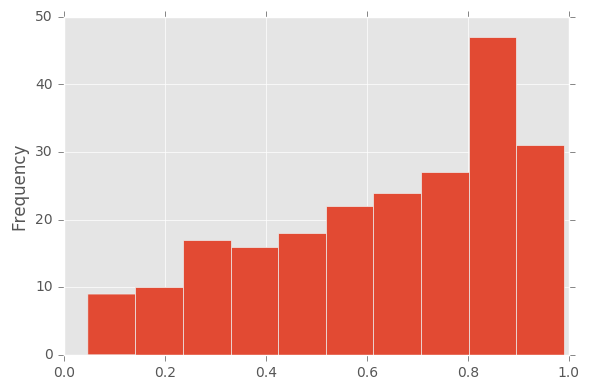

In [96]:
plot = matches['tsWin_x'].plot(kind = 'hist')
fig = plot.get_figure()
plt.tight_layout()
fig.savefig("TrueSkill.png", dpi = 400)